In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

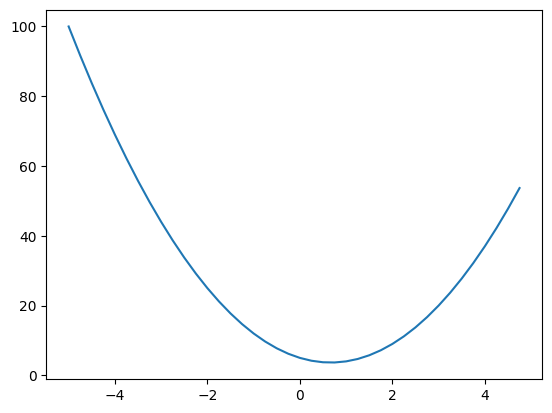

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
# Let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [45]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

# Derivative of d with respect to a, b, c
d1 = a * b + c

# Derivative of d with respect to a (increased by h (limit approaching 0))
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)

#(d2 - d1) amount function increases (d changed) when bumped by specific input (d2 increased by a), normalized by h to retrieve slope
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [152]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data # Weights of neural net; Some fixed, some impact loss function (L) which gradient tracks
        self.grad = 0.0 # Gradient, represents derivative of loss function/output (L) with respect to value (a, b, c, d, e, f)
        self._backward = lambda: None # Helps with chain rule; stores the way the output gradient is chained into the input gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # If other is instance of Value, leave it alone. Otherwise, assume it's an integer/float & wrap it in Value (e.g. a + Value(2.0))
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        # Function that propagates the gradient
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        # If other is instance of Value, leave it alone. Otherwise, assume it's an int/float & wrap it in Value (e.g. a * Value(2.0))
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        # Function that propagates the gradient
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now" # other is the 'power', forced to be int/float
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad # (e.g. 3x^3 = 9x^2)
        out._backward = _backward

        return out
        
    def __rmul__(self, other): # Reverse of __mul__, other * self (e.g. 2.0 * a = a * 2.0)
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # Reverse of __add__, other + self (e.g. 2.0 + a = a + 2.0)
        return self + other
        
    # Tanh function (hyperbolic)
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        # Function that propagates the gradient
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # e^x derivative is e^x
        out._backward = _backward

        return out
        
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        
        # Gradient for each node
        for node in reversed(topo):
            node._backward()
            


In [23]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [ ]:
'''
# Division can be broken down as follows

a / b
a * (1 / b)
a * (b**-1)
'''

In [30]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [27]:
# inputs x1, x2 (two dimensional neuron, two inputs)
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1, w2 (weights of the neuron, synaptic strengths of each input)
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron (the higher the value, the closer to the tail (top) it will be; plateaus near 1) 
b = Value(6.8813735870195432, label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Cell body raw activation (without the activation)
n = x1w1x2w2 + b; n.label = 'n'

# Activation function (returns tanh function of n)
o = n.tanh(); o.label = 'o'
o.backward()

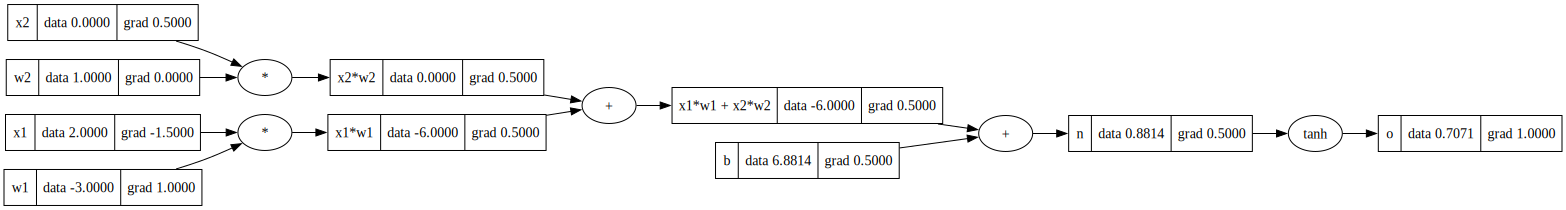

In [28]:
draw_dot(o)

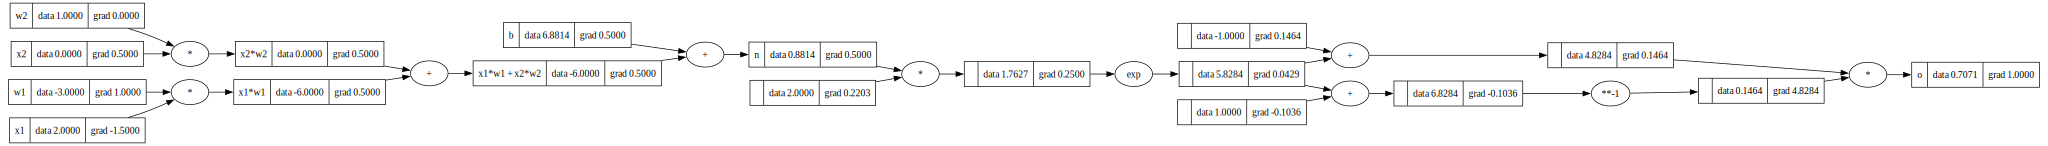

In [32]:
# inputs x1, x2 (two dimensional neuron, two inputs)
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1, w2 (weights of the neuron, synaptic strengths of each input)
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron (the higher the value, the closer to the tail (top) it will be; plateaus near 1) 
b = Value(6.8813735870195432, label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Cell body raw activation (without the activation)
n = x1w1x2w2 + b; n.label = 'n'

# -------
# Activation function (returns tanh function of n)
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# -------
o.label = 'o'
o.backward()
draw_dot(o)

In [35]:
import torch

In [55]:
import random

In [39]:
# 2x3 array of scalar values
torch.Tensor([[1, 2, 3], [4, 5, 6]])
#torch.Tensor([[1, 2, 3], [4, 5, 6]]).shape

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [64]:
# Modern deep neural network library implementing the above via API
# Micrograd, as implemented above, is a scalar valued engine (only uses scalar values)
# Pytorch uses tensors, which are n-dimensional array of scalars

# Cast as python defaults to double precision (float64) for floating point numbers, by default tensors are float32 (single precision)
# Since these are leaf nodes, by default Pytorch assumes they do not require gradients (efficiency reasons as usually leaf nodes don't have gradients (input to network))
# Scalar valued one element tensors
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [53]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [1737]:
class Neuron:
    # Constructor receives number of inputs (nin) to this neuron
    def __init__(self, nin):
        # Weight for every one of the inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # Bias that controls the overall trigger happiness of this neuron
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b (w * x is a dot product)
        # zip takes two iterators & creates new iterator that iterates over tuples of the corresponding entries
        # print(list(zip(self.w, x)))
        
        # Dot product (iterates over wi & xi, multiplies them, and sums them all up), raw activation 
        # Adding self.b to sum() starts (initializes) the addition with self.b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # Pass through non-linearity
        out = act.tanh()
        return out

    # Collect parameters of neural net (neurons) all in one array; parameter scalars
    def parameters(self):
        # Returns list of weights concatenated with a list of self.b
        return self.w + [self.b]


# Layer of neurons is set of neurons evaluated independently
class Layer:
    
    # List of neurons; nout = number of neurons/output in layer; nin = initialize neurons with given dimensionality
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    # Independently evaluate neurons
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # if single element, return value without list
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        '''
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps) # Put neuron parameters on top of params
        return params
        '''
        
class MLP:

    # nouts = list defines the sizes of all layers in MLP
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        # Iterate over consecutive pairs of these sizes and create layer objects for them
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    # Call sequentially
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [1861]:
x = [2.0, 3.0, -1.0] # 3 input neurons (3 dimensional input)
n = MLP(3, [4, 4, 1]) # 3 inputs into two layers of four and one output
n(x) # Feed numbers into neuron to get output, forward pass of MLP

Value(data=0.29576300088237634)

In [1739]:
# All weight & biases inside the entire neural net
n.parameters()

[Value(data=0.484142491817249),
 Value(data=-0.2593592038382062),
 Value(data=-0.9107016612853636),
 Value(data=0.7438379344568031),
 Value(data=-0.9660700828811641),
 Value(data=-0.9443209319864649),
 Value(data=-0.6724569343264495),
 Value(data=0.7508869340527551),
 Value(data=-0.4260925369330155),
 Value(data=-0.3336760320834351),
 Value(data=-0.08116439629630423),
 Value(data=-0.4783938340174714),
 Value(data=0.6751295573247844),
 Value(data=-0.8126750761528532),
 Value(data=0.4423704307421794),
 Value(data=0.710387304181737),
 Value(data=-0.7635970126818403),
 Value(data=-0.21963960659522574),
 Value(data=-0.9865129915344815),
 Value(data=-0.1992059158892494),
 Value(data=0.38275050042116243),
 Value(data=0.5021789716256038),
 Value(data=-0.9555480860014143),
 Value(data=0.7510464146545457),
 Value(data=0.32462375507844166),
 Value(data=-0.3265086529673904),
 Value(data=-0.3459427804215094),
 Value(data=-0.6589041438916636),
 Value(data=-0.15930025662842562),
 Value(data=0.4073530

In [118]:
x = [2.0, 3.0] # input
n = Neuron(2) # 2 dimensional neuron
n(x) # Feed numbers into neuron to get output

Value(data=-0.9998370200096578)

In [1862]:
# Binary classifier neural net
# Data set has four inputs into the neural net
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# Desired targets; first row corresponds to first in list, second row to the second in list, etc
ys = [1.0, -1.0, -1.0, 1.0]

In [1741]:
# Single number that measures the total performance of neural net, how well it's doing
# If predictions are not close to desired targets, loss is high
# Mean squared error loss; for y ground truth & y output (pair ygt & ypred in tuple)
# for each ygt & yout (ground truth/desired target & pred/output), subtract & square
# Square ensures a positive number
# When yout - ygt = 0, prediction is exactly the target; the more off the prediction, the higher the loss
# [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]


# What neural net currently thinks about predictions
ypred = [n(x) for x in xs]
ypred

# Sum of all loss
#loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
#loss

[Value(data=-0.27586513161887616),
 Value(data=-0.8676427621020607),
 Value(data=-0.4764704166111203),
 Value(data=-0.43465061647287623)]

In [1742]:
# What neural net currently thinks about predictions
ypred = [n(x) for x in xs]

# Sum of all loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.977655888534162)

In [1867]:
# Minimizes loss
for k in range(20):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update (gradient descent)
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.030831022763982033
1 0.029764375758085503
2 0.028761128676730377
3 0.027815924636483004
4 0.02692398888014871
5 0.026081052302013633
6 0.02528328665440346
7 0.024527249414746703
8 0.023809836680778663
9 0.023128242768197648
10 0.02247992542862879
11 0.021862575800237788
12 0.02127409235948325
13 0.02071255826849061
14 0.020176221614698703
15 0.019663478122656237
16 0.019172855985946754
17 0.0187030025231838
18 0.018252672408191947
19 0.017820717262738556


In [1868]:
ypred

[Value(data=0.9110752517531904),
 Value(data=-0.9644456198103897),
 Value(data=-0.9114455759149654),
 Value(data=0.9715903812718195)]

In [1805]:
# Minimize loss (if loss is low, every prediction is equal to its target)
loss.backward()

In [1806]:
# Gradient of particular weight of particular neuron of particular layer; influence on loss is negative
# Slightly increasing particular weight of neuron of this layer would make loss go down
n.layers[0].neurons[0].w[0].grad

-1.5260607293580954

In [1807]:
# Value of neuron
n.layers[0].neurons[0].w[0].data

0.5890506209775551

In [1808]:
# Tiny update in gradient descent scheme
# Gradient descent = Imagine gradient as a vector pointing in the direction of increased loss
# Thus modify p.data by a small step size in the opposite direction of the gradient to decrease loss (goal is to minimize loss)
# In total: gradient descent is forward pass, backward pass, update, repeat
for p in n.parameters():
    p.data += -0.01 * p.grad

In [1758]:
n.layers[0].neurons[0].w[0].data

0.47903795194130777

In [1810]:
ypred

[Value(data=0.9664899965110032),
 Value(data=-0.9844450789527933),
 Value(data=-0.987088420880275),
 Value(data=0.9869513212296455)]

In [1811]:
n.parameters()

[Value(data=0.604311228271136),
 Value(data=0.04493566040968181),
 Value(data=-0.33760694914313766),
 Value(data=1.1449050816627406),
 Value(data=-0.7071204878208154),
 Value(data=-0.6683936206188119),
 Value(data=-1.5888352516419622),
 Value(data=0.9259416858704562),
 Value(data=-0.37807425758647184),
 Value(data=-0.26944658109981845),
 Value(data=0.38973670868352706),
 Value(data=-0.323141963246632),
 Value(data=0.11256980835257623),
 Value(data=-1.2048953719719522),
 Value(data=2.0005376369507446),
 Value(data=0.7940104749001818),
 Value(data=-0.6221083925623834),
 Value(data=-0.23174030250084815),
 Value(data=-1.0526299330161981),
 Value(data=-0.33043989517867556),
 Value(data=0.45035414472824176),
 Value(data=-0.17758230406671777),
 Value(data=-1.1078516129734772),
 Value(data=0.7954888492454508),
 Value(data=1.0887563444943311),
 Value(data=-0.287910585365649),
 Value(data=-0.46591164650106703),
 Value(data=-0.8195763240496159),
 Value(data=-0.26740935396648424),
 Value(data=0.68

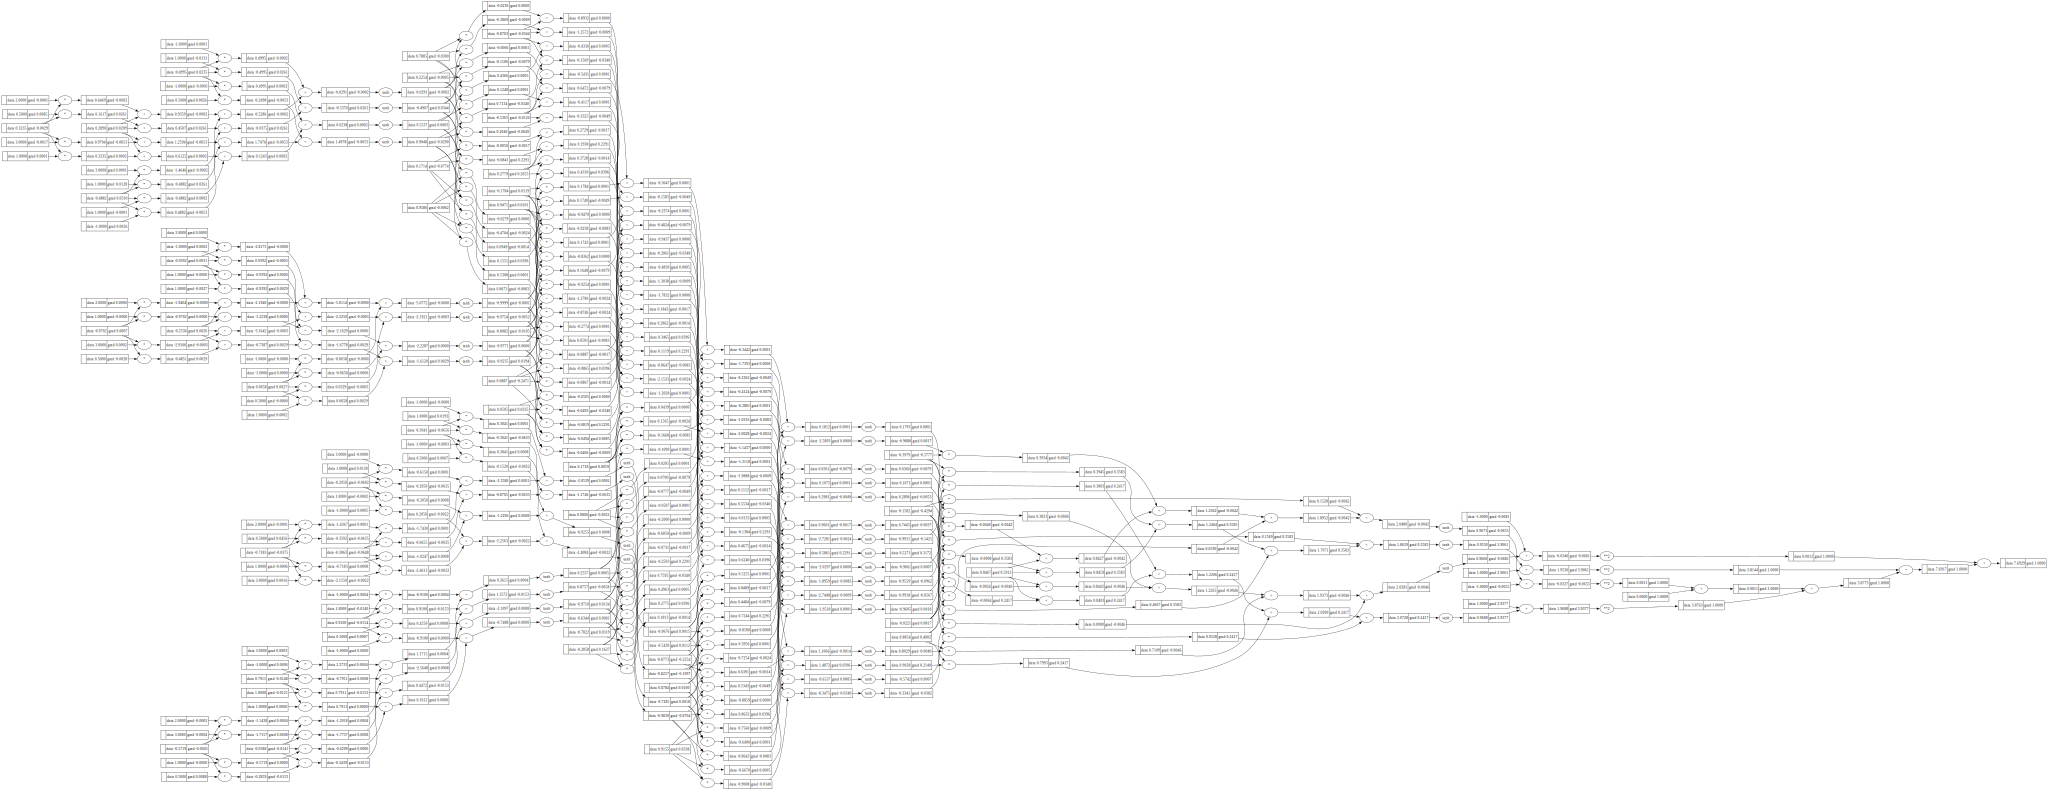

In [168]:
# Four forward passes of neural net for every one of the examples, plus the loss on top
# Loss backpropagates through all forward passes, through every intermediate value in neural net, to input values
draw_dot(loss)